In [3]:
import warnings
warnings.filterwarnings('ignore')
from autogluon.multimodal import MultiModalPredictor
import pandas as pd

- folder
  - images/*
  - labels.csv : image_path, label


images : labels as folder name
table : images as encoded column
multi_target

In [5]:
vision_unprocessed = pd.read_csv("./sample_data/frames.csv")

In [6]:
vision_unprocessed.head()

,id,frame_number,frame_timestamp,number_of_faces,eyes_closed,yawning,alert,frame_data,driving_log_id
0,2526f3cf-7952-4aa4-8b12-d45b43c8ee46,83,2025-02-25T09:28:32.132828+02:00,1,False,False,False,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQ...,222
1,c0d6fe94-4370-47ae-9289-76df29c9f233,84,2025-02-25T09:28:32.419121+02:00,1,False,False,False,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQ...,222
2,47f87642-6be9-4c41-893e-978a17b6cc8d,85,2025-02-25T09:28:32.650903+02:00,1,False,False,False,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQ...,222
3,79953087-3c90-415a-be61-df89d42e6487,86,2025-02-25T09:28:32.874225+02:00,1,False,False,False,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQ...,222
4,5ac1d1e2-aa83-432b-9fb5-fb62f1f6bc6a,87,2025-02-25T09:28:33.090240+02:00,1,False,False,False,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQ...,222


In [ ]:
vision_unprocessed.yawning.value_counts()

yawning
False    80
Name: count, dtype: int64

In [51]:
vision_unprocessed.eyes_closed.value_counts()

eyes_closed
False    69
True     11
Name: count, dtype: int64

In [19]:
test_frame_data = vision_unprocessed.iloc[40]['frame_data']
test_frame_data

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+H+iiigAooooAKKKKACiiigAooooA/wBPSJicluSARuAOM7jnOTkNjkc9cH1FSo2T1xg4x6AHknnuc/mc9RVJG6DJxkKeV55fOeMjnBPHUrzkc2N6pt442csMddz8HpzgZGecbQCWBY8+jdu7Vk+jvP59k/8At3Q87TV20T3

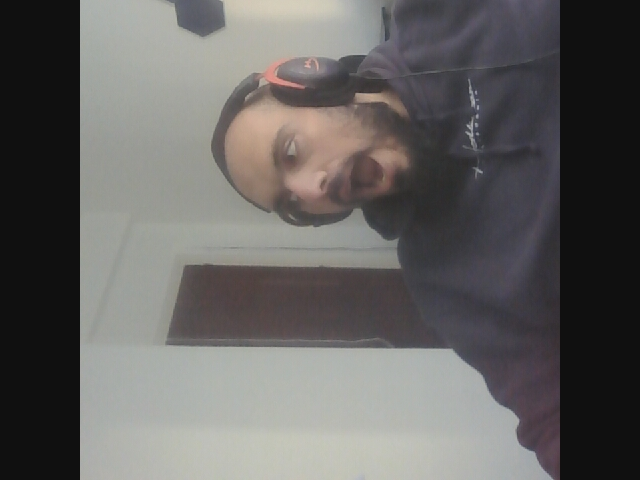

In [20]:
import base64
from PIL import Image
import io
imgdata = base64.b64decode(test_frame_data)
Image.open(io.BytesIO(imgdata))

In [43]:
import os
from tqdm import tqdm
from pathlib import Path

def decode_image(image_str: str) -> Image.Image:
    """Decode a base64-encoded image string into a PIL Image."""
    return Image.open(io.BytesIO(base64.b64decode(image_str)))

# Paths
ds_path = Path("./sample_data/drowsiness_detection/")
os.makedirs(ds_path, exist_ok=True)

records = []

# Iterate efficiently
for row in tqdm(vision_unprocessed.itertuples(index=True), total=len(vision_unprocessed)):
    image_path = ds_path / f"{row.Index}.png"
    img = decode_image(row.frame_data)
    img.save(image_path)
    records.append({"image_path": str(image_path), "label": row.alert})

# Save labels CSV
labels_df = pd.DataFrame(records)
labels_df.to_csv(ds_path / "labels.csv", index=False)


100%|██████████| 80/80 [00:01<00:00, 61.21it/s]


In [49]:
labels_df.label.value_counts()

label
False    78
True      2
Name: count, dtype: int64

In [44]:
from autogluon.multimodal import MultiModalPredictor

In [53]:
predictor = MultiModalPredictor(label= "label")
leaderboard = predictor.fit(
    train_data= str(ds_path/"labels.csv"), 
    time_limit= 30
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250815_111514"
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:29 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T6030
CPU Count:          11
Pytorch Version:    2.6.0
CUDA Version:       CUDA is not available
Memory Avail:       4.44 GB / 18.00 GB (24.7%)
Disk Space Avail:   40.06 GB / 460.43 GB (8.7%)
Loaded data from: sample_data/drowsiness_detection/labels.csv | Columns = 2 / 2 | Rows = 80 -> 80
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.False_, np.True_]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'qua

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/autogluon/multimodal/data/templates.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/autogluon/multimodal/data/templates.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s]                             

/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/autogluon/multimodal/data/templates.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/autogluon/multimodal/data/templates.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Epoch 0: 100%|██████████| 8/8 [00:18<00:00,  0.42it/s]

Epoch 0, global step 1: 'val_roc_auc' reached 0.00000 (best 0.00000), saving model to '/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/AutogluonModels/ag-20250815_111514/epoch=0-step=1.ckpt' as top 3


Epoch 1:  50%|█████     | 4/8 [00:05<00:05,  0.70it/s]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 1:  62%|██████▎   | 5/8 [00:07<00:04,  0.69it/s]


AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/AutogluonModels/ag-20250815_111514")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
leaderboard.

'roc_auc'

In [1]:
!uv add timm lightning

Resolved 257 packages in 508ms                                       
Audited 239 packages in 0.68ms


In [2]:
import torch
from timm import create_model
from torchvision import transforms, datasets
import lightning as L


/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def __init__(
    self,
    train_captions,
    root_dir,
    transform=None,
    bert_model="distilbert-base-uncased",
    max_len=512,
):
    self.df = pd.read_csv(train_captions, header=None, sep="|")
    self.root_dir = root_dir
    self.transform = transform
    self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
    self.max_len = max_len

    self.images = self.df.iloc[:, 0]
    self.captions = self.df.iloc[:, 2]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.images[idx]
        path_to_image = os.path.join(self.root_dir, image_id)
        image = Image.open(path_to_image).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        tokenized_caption = self.tokenizer(
            caption,
            padding="max_length",  # Pad to max_length
            truncation=True,  # Truncate to max_length
            max_length=self.max_len,
            return_tensors="pt",
        )["input_ids"]

        return image, tokenized_caption


DEFAULT_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


class LitClassification(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = create_model("resnet34", num_classes=196)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def training_step(self, batch):
        images, targets = batch
        outputs = self.model(images)
        loss = self.loss_fn(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.005)


class ClassificationData(L.LightningDataModule):

    def train_dataloader(self):
        train_dataset = datasets.StanfordCars(
            root=".", download=False, transform=DEFAULT_TRANSFORM
        )
        return torch.utils.data.DataLoader(
            train_dataset, batch_size=256, shuffle=True, num_workers=5
        )


if __name__ == "__main__":
    model = LitClassification()
    data = ClassificationData()
    trainer = L.Trainer(max_epochs=20, max_time={"seconds": 30})
    trainer.fit(model, data)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 21.4 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.541    Total estimated model params size (MB)
167       Modules in train mode
0         Modules in eval mode


RuntimeError: Dataset not found. Try to manually download following the instructions in https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616.

In [1]:
import torch
from timm import create_model as create_model_timm
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import lightning as L
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import pandas as pd
import os

/Users/smukherjee/Documents/Projects/ALFIE/alfie_automl_engine/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:

class ImageClassificationFromCSVDataset(Dataset):
    def __init__(
        self, 
        csv_file: str, 
        root_dir: str, 
        img_col: str = "image", 
        label_col: str = "label", 
        transform=None
    ) -> None:
        super().__init__()
        if isinstance(csv_file, str):
            self.label_csv = pd.read_csv(csv_file)
        elif isinstance(csv_file, pd.DataFrame):
            self.label_csv = csv_file.reset_index(drop=True)
        else:
            raise ValueError("data must be either a CSV file path or a pandas DataFrame")

        self.root_dir = root_dir
        self.img_col = img_col
        self.label_col = label_col
        if transform is None:
            self.transform = T.Compose([
                T.Resize(256),                # resize shortest side
                T.CenterCrop(224),            # crop to 224x224
                T.ToTensor(),                 # convert PIL image to tensor
                T.Normalize(                  # normalize with ImageNet stats
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transform

        if self.label_csv[self.label_col].dtype not in [int, float]:
            self.classes = sorted(self.label_csv[self.label_col].unique().tolist())
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
            self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

            # Replace labels with integer indices
            self.label_csv[self.label_col] = self.label_csv[self.label_col].map(self.class_to_idx)

    def __len__(self):
        return len(self.label_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()

        label = int(self.label_csv.iloc[idx][self.label_col])
        img_path = os.path.join(
            self.root_dir, 
            self.idx_to_class[label],   
            self.label_csv.iloc[idx][self.img_col]
        )

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [20]:
# Dataloaders

class ClassificationData(L.LightningDataModule):
    def __init__(
        self,
        csv_file,
        root_dir,
        img_col="filename",
        label_col="label",
        batch_size=32,
        num_workers=0,
        transform=None,
        shuffle=True,
        val_split=0.2,
        test_split=0.1,
        seed=42,
    ):
        super().__init__()
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.img_col = img_col
        self.label_col = label_col
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.shuffle = shuffle
        self.val_split = val_split
        self.test_split = test_split
        self.seed = seed

        self.num_classes = 0
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage=None):
        # load dataframe
        df = pd.read_csv(self.csv_file)

        # stratified split train vs temp (val+test)
        train_df, temp_df = train_test_split(
            df,
            test_size=self.val_split + self.test_split,
            stratify=df[self.label_col],
            random_state=self.seed,
        )

        # split temp into val and test
        relative_val = self.val_split / (self.val_split + self.test_split)
        val_df, test_df = train_test_split(
            temp_df,
            test_size=1 - relative_val,
            stratify=temp_df[self.label_col],
            random_state=self.seed,
        )

        # create datasets
        self.train_dataset = ImageClassificationFromCSVDataset(
            csv_file=train_df,
            root_dir=self.root_dir,
            img_col=self.img_col,
            label_col=self.label_col,
            transform=self.transform,
        )
        self.val_dataset = ImageClassificationFromCSVDataset(
            csv_file=val_df,
            root_dir=self.root_dir,
            img_col=self.img_col,
            label_col=self.label_col,
            transform=self.transform,
        )
        self.test_dataset = ImageClassificationFromCSVDataset(
            csv_file=test_df,
            root_dir=self.root_dir,
            img_col=self.img_col,
            label_col=self.label_col,
            transform=self.transform,
        )

        self.num_classes = len(self.train_dataset.classes)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )


class LitClassification(L.LightningModule):
    def __init__(self, model_fn, lr=0.001, loss_fn=None):
        """
        model_fn: callable returning a torch.nn.Module (e.g. lambda nc: resnet34(num_classes=nc))
        num_classes: number of classes in dataset
        lr: learning rate
        loss_fn: optional custom loss function
        """
        super().__init__()
        self.save_hyperparameters(ignore=["model_fn", "loss_fn"])

        self.model = model_fn()
        self.loss_fn = loss_fn if loss_fn is not None else torch.nn.CrossEntropyLoss()
        self.lr = lr

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.model(images)
        loss = self.loss_fn(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)



In [21]:
# Store dataset id
if __name__ == "__main__":
    datamodule = ClassificationData(
        csv_file="./sample_data/Garbage_Dataset_Classification/metadata.csv",
        root_dir="./sample_data/Garbage_Dataset_Classification/images",
        img_col="filename",
        label_col="label",
        batch_size=256,
    )

    # Define model module
    model = LitClassification(
        model_fn=create_model_timm('resnet34', pretrained=True, num_classes = datamodule.num_classes),
        lr=0.005,
    )

    trainer = L.Trainer(max_epochs=1, fast_dev_run=False)
    trainer.fit(model, datamodule)

TypeError: ResNet.forward() missing 1 required positional argument: 'x'

In [ ]:
# default config - transforms, loss functions, optimizer

In [ ]:
# SQL table with models

In [ ]:
# Load network with final layer

In [ ]:
# Sql table with runs linked to models and datasets

In [38]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from timm import create_model as create_model_timm
from tqdm import tqdm
import lightning as L  # for Fabric

In [39]:

# -----------------------------
# Dataset
# -----------------------------
class ImageClassificationFromCSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, img_col="image", label_col="label", transform=None):
        if isinstance(csv_file, str):
            self.label_csv = pd.read_csv(csv_file)
        elif isinstance(csv_file, pd.DataFrame):
            self.label_csv = csv_file.reset_index(drop=True)
        else:
            raise ValueError("csv_file must be a path or DataFrame")
        
        self.root_dir = root_dir
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform or T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Encode labels
        if self.label_csv[self.label_col].dtype not in [int, float]:
            self.classes = sorted(self.label_csv[self.label_col].unique().tolist())
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
            self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
            self.label_csv[self.label_col] = self.label_csv[self.label_col].map(self.class_to_idx)
        else:
            self.classes = sorted(self.label_csv[self.label_col].unique().tolist())
            self.class_to_idx = {cls: cls for cls in self.classes}
            self.idx_to_class = {cls: cls for cls in self.classes}

    def __len__(self):
        return len(self.label_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        label = int(self.label_csv.iloc[idx][self.label_col])
        img_path = os.path.join(
            self.root_dir,
            self.idx_to_class[label],        # folder named after label
            self.label_csv.iloc[idx][self.img_col]
        )
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


In [40]:


# -----------------------------
# Data module replacement
# -----------------------------
class ClassificationData:
    def __init__(self, csv_file, root_dir, img_col="filename", label_col="label",
                 batch_size=32, num_workers=0, transform=None, shuffle=True,
                 val_split=0.2, test_split=0.1, seed=42):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.img_col = img_col
        self.label_col = label_col
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.shuffle = shuffle
        self.val_split = val_split
        self.test_split = test_split
        self.seed = seed
        self.num_classes = 0
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.setup()

    def setup(self):
        df = pd.read_csv(self.csv_file)
        train_df, temp_df = train_test_split(df,
                                             test_size=self.val_split + self.test_split,
                                             stratify=df[self.label_col],
                                             random_state=self.seed)
        relative_val = self.val_split / (self.val_split + self.test_split)
        val_df, test_df = train_test_split(temp_df,
                                           test_size=1 - relative_val,
                                           stratify=temp_df[self.label_col],
                                           random_state=self.seed)
        self.train_dataset = ImageClassificationFromCSVDataset(train_df, self.root_dir,
                                                               self.img_col, self.label_col,
                                                               self.transform)
        self.val_dataset = ImageClassificationFromCSVDataset(val_df, self.root_dir,
                                                             self.img_col, self.label_col,
                                                             self.transform)
        self.test_dataset = ImageClassificationFromCSVDataset(test_df, self.root_dir,
                                                              self.img_col, self.label_col,
                                                              self.transform)
        self.num_classes = len(self.train_dataset.classes)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=self.shuffle, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)



In [ ]:

# -----------------------------
# Model
# -----------------------------
class ClassificationModel(nn.Module):
    def __init__(self, model_name="resnet34", num_classes=2, pretrained=True):
        super().__init__()
        self.model = create_model_timm(model_name, pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
class EarlyStopping:
    def __init__(self, monitor="val_loss", patience=3, min_delta=0.0):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.best = float("inf")
        self.counter = 0
        self.stop_training = False

    def on_epoch_end(self, trainer, epoch, logs):
        current = logs.get(self.monitor)
        if current is None:
            return
        if current < self.best - self.min_delta:
            self.best = current
            self.counter = 0
        else:
            self.counter += 1
            trainer.fabric.print(
                f"EarlyStopping counter: {self.counter}/{self.patience}"
            )
            if self.counter >= self.patience:
                trainer.fabric.print("Early stopping triggered!")
                trainer.epochs = epoch + 1  # force exit after current epoch


class FabricTrainer:
    def __init__(
        self,
        datamodule,
        model_class,
        model_kwargs=None,
        optimizer_class=optim.AdamW,
        optimizer_kwargs=None,
        loss_fn=nn.CrossEntropyLoss(),
        lr=0.001,
        epochs=1,
        time_limit=None,
        device="auto",
        callbacks=None,
        input_dtype=torch.float32,
        target_dtype=torch.long,
    ):
        """
        Modular Lightning Fabric trainer with callback support and automatic device/dtype handling.

        Args:
            datamodule: Lightning-style datamodule with train/val/test loaders.
            model_class: Class of the model to train.
            model_kwargs: Dict of kwargs for the model initialization.
            optimizer_class: Optimizer class.
            optimizer_kwargs: Dict of kwargs for optimizer initialization.
            loss_fn: Loss function.
            lr: Learning rate (used if optimizer_kwargs not provided).
            epochs: Number of epochs to train.
            time_limit: Optional time limit in seconds.
            device: Optional device string (e.g., "cuda" or "cpu").
            callbacks: List of callback instances implementing on_epoch_end(trainer, epoch, logs) method.
            input_dtype: dtype for input tensors (default: torch.float32).
            target_dtype: dtype for target tensors (default: torch.long).
        """
        self.datamodule = datamodule
        self.model_class = model_class
        self.model_kwargs = model_kwargs or {}
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs or {"lr": lr}
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.time_limit = time_limit
        self.device = device
        self.callbacks = callbacks or []
        self.input_dtype = input_dtype
        self.target_dtype = target_dtype

        # Setup fabric
        self.fabric = L.Fabric(devices=self.device)
        self._setup_model_optimizer()

    def _setup_model_optimizer(self):
        self.model = self.model_class(**self.model_kwargs)
        self.optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )

        train_loader = self.datamodule.train_dataloader()
        val_loader = self.datamodule.val_dataloader()
        self.model, self.optimizer, self.train_loader, self.val_loader = (
            self.fabric.setup(self.model, self.optimizer, train_loader, val_loader)
        )
        self.test_loader = self.datamodule.test_dataloader()

    def _move_batch(self, imgs, labels):
        """Move inputs and labels to fabric device and correct dtype"""
        imgs = imgs.to(self.fabric.device, dtype=self.input_dtype)
        labels = labels.to(self.fabric.device, dtype=self.target_dtype)
        return imgs, labels

    def train_epoch(self, epoch, start_time):
        self.model.train()
        running_loss = 0.0
        for imgs, labels in tqdm(
            self.train_loader, desc=f"Epoch {epoch+1} Training", leave=False
        ):
            # Check time limit per batch
            if self._check_time_limit(start_time):
                return running_loss / max(
                    1, len(self.train_loader)
                )  # return average loss so far

            imgs, labels = self._move_batch(imgs, labels)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss = self.loss_fn(outputs, labels)
            self.fabric.backward(loss)
            self.optimizer.step()
            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def validate(self, start_time):
        self.model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                if self._check_time_limit(start_time):
                    break
                imgs, labels = self._move_batch(imgs, labels)
                outputs = self.model(imgs)
                loss = self.loss_fn(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_loss = val_loss / max(1, len(self.val_loader))
        acc = correct / max(1, total)
        self.fabric.print(f"Val Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}")
        return avg_loss, acc

    def test(self):
        self.model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(self.test_loader, desc="Testing"):
                imgs, labels = self._move_batch(imgs, labels)
                outputs = self.model(imgs)
                loss = self.loss_fn(outputs, labels)
                test_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_loss = test_loss / len(self.test_loader)
        acc = correct / total
        self.fabric.print(f"\nTest Loss: {avg_loss:.4f}, Test Acc: {acc:.4f}")
        return avg_loss, acc

    def _check_time_limit(self, start_time):
        if self.time_limit and (time.time() - start_time) > self.time_limit:
            self.fabric.print("Time limit reached. Stopping training.")
            return True
        return False

    def fit(self):
        start_time = time.time()
        for epoch in range(self.epochs):
            train_loss = self.train_epoch(epoch, start_time)
            val_loss, val_acc = self.validate(start_time)

            logs = {"train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc}
            for cb in self.callbacks:
                cb.on_epoch_end(self, epoch, logs)

            if self._check_time_limit(start_time):
                break
        return self.test()

In [ ]:

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    datamodule = ClassificationData(
        csv_file="./sample_data/Garbage_Dataset_Classification/metadata.csv",
        root_dir="./sample_data/Garbage_Dataset_Classification/images",
        img_col="filename",
        label_col="label",
        batch_size=64,
    )

    # time_limit in seconds (optional, None = no limit)
    trainer = FabricTrainer(
    datamodule=datamodule,
    model_class=ClassificationModel,
    model_kwargs={"model_name": "resnet34", "num_classes": datamodule.num_classes, "pretrained": True},
    optimizer_class=optim.AdamW,
    optimizer_kwargs={"lr": 0.001},
    loss_fn=nn.CrossEntropyLoss(),
    epochs=10,
    callbacks=[],
    time_limit= 10 
    )
    trainer.fit()


Time limit reached. Stopping training.


Time limit reached. Stopping training.
Val Loss: 0.0000, Val Acc: 0.0000
Time limit reached. Stopping training.


Testing: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s]


Test Loss: 1.3680, Test Acc: 0.5723


: 